In [121]:
import os, sys, random, glob, time, shutil
import numpy as np
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt
from models import TransformerNet, VGG16
from utils  import (
    gram_matrix,
    train_transform,
    style_transform,
    denormalize
)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
MEMFMT = torch.channels_last
device

device(type='mps')

In [122]:
# DATA
DATASET_PATH = "data/train2014_40k"           # ↔ any ImageFolder-style dir
STYLE_PATH   = "data/stylized/paysanne-couchant-1882.jpg"

# TRAINING
EPOCHS          = 5
BATCH_SIZE      = 12
IMAGE_SIZE      = 256
STYLE_SIZE      = 256     # None ⇒ keep original
LAMBDA_CONTENT  = 1e5
LAMBDA_STYLE    = 1e10
LR              = 1e-3
CHECK_EVERY     = 500     # save sample & checkpoint
TV_ACTIVE       = True   # ↔ False ⇒ no TV loss
OUT_DIR         = "data/output_40k_5epochs_tv_2"
os.makedirs(OUT_DIR, exist_ok=True)


In [123]:
train_ds = datasets.ImageFolder(DATASET_PATH, train_transform(IMAGE_SIZE))
train_dl = DataLoader(train_ds, 
                      batch_size=BATCH_SIZE, 
                      shuffle=True,
                      num_workers=os.cpu_count(), 
                      persistent_workers=True)

print(f"{len(train_ds):,} training images")

40,000 training images


In [124]:
transformer = TransformerNet().to(device, memory_format=MEMFMT)
vgg         = VGG16(requires_grad=False).to(device, memory_format=MEMFMT)

optim       = torch.optim.Adam(transformer.parameters(), LR)
mse_loss    = torch.nn.MSELoss()

# style image ➜ features ➜ gram matrices
style_img   = style_transform(STYLE_SIZE)(Image.open(STYLE_PATH)).unsqueeze(0).to(device)
style_img   = style_img.repeat(BATCH_SIZE,1,1,1)          # match batch
with torch.no_grad():
    style_feats = vgg(style_img)
    style_grams = [gram_matrix(f) for f in style_feats]


In [125]:
def save_sample(step, inputs, outputs):
    """inputs/outputs are *denormalised* tensors in range [0,1]"""
    grid = torch.cat((inputs, outputs), dim=2)        # side-by-side
    vutils.save_image(grid, f"{OUT_DIR}/{step:06}.jpg", nrow=4)

def tensor_to_vis(t):
    """(B,C,H,W) tensor → (B,H,W,C) uint8 numpy 0-255"""
    t = denormalize(t.clone()).clamp(0,1).mul(255).byte()
    return t.permute(0,2,3,1).cpu().numpy()


In [126]:
# ─── helper: total-variation loss (define once, outside the loop) ──────────────
def tv_loss(x):
    """
    Total-variation regularizer: encourages spatial smoothness.
    """
    return (
        (x[:, :, :-1, :] - x[:, :, 1:, :]).abs().sum() +       # vertical diffs
        (x[:, :, :, :-1] - x[:, :, :, 1:]).abs().sum()         # horizontal diffs
    )

TV_WEIGHT = 1e-6     # tweak 1e-6 ↔ 1e-5 to taste

In [127]:
# ─── training loop with optional TV loss ───────────────────────────────────────
global_step = 0
start_time = time.time()

for epoch in range(EPOCHS):
    for batch_i, (imgs, _) in enumerate(train_dl, 1):
        imgs = imgs.to(device, memory_format=MEMFMT)
        optim.zero_grad()

        # ─ forward pass ─
        preds        = transformer(imgs)
        feats_preds  = vgg(preds)
        feats_imgs   = vgg(imgs)

        # ─ content loss ─
        loss_content = LAMBDA_CONTENT * mse_loss(
            feats_preds.relu2_2, feats_imgs.relu2_2
        )

        # ─ style loss ─
        loss_style = 0.0
        for f_pred, g_style in zip(feats_preds, style_grams):
            g_pred = gram_matrix(f_pred)
            loss_style += mse_loss(g_pred, g_style[: imgs.size(0), ...])
        loss_style *= LAMBDA_STYLE

        # ─ optional total-variation loss ─
        loss_tv = TV_WEIGHT * tv_loss(preds) if TV_ACTIVE else 0.0

        # ─ combined loss ─
        loss = loss_content + loss_style + loss_tv
        
        loss.backward()
        optim.step()

        # ─ logging / checkpointing ─
        if global_step % 20 == 0 or batch_i == len(train_dl):
            loss_log =(
                f"[Ep {epoch+1}/{EPOCHS}] [It {batch_i}/{len(train_dl)}] "
                f"C:{loss_content.item():.1f}  "
                f"S:{loss_style.item():.1f}  "
                f"TV:{loss_tv.item() if TV_ACTIVE else 0:.3f}  "
                f"Tot:{loss.item():.1f}"
            )
            print(loss_log)
            
            # Save loss log to file
            with open(f"{OUT_DIR}/loss_log.txt", "a") as f:
                f.write(loss_log + "\n")

        if global_step % CHECK_EVERY == 0:
            with torch.no_grad():
                out_vis = transformer(imgs).detach()
            save_sample(global_step,
                        denormalize(imgs.clone()),
                        denormalize(out_vis.clone()))
            torch.save(
                transformer.state_dict(),
                f"{OUT_DIR}/ckpt_{global_step:06}.pth"
            )

        global_step += 1


[Ep 1/5] [It 1/3334] C:907465.2  S:2683462.2  TV:0.795  Tot:3590928.2
[Ep 1/5] [It 21/3334] C:944374.2  S:2160741.0  TV:0.751  Tot:3105116.0
[Ep 1/5] [It 41/3334] C:867784.7  S:1812885.9  TV:0.703  Tot:2680671.2
[Ep 1/5] [It 61/3334] C:881651.9  S:1533360.2  TV:0.691  Tot:2415012.8
[Ep 1/5] [It 81/3334] C:878687.0  S:1391052.4  TV:0.697  Tot:2269740.2
[Ep 1/5] [It 101/3334] C:769616.7  S:1320735.6  TV:0.662  Tot:2090352.9
[Ep 1/5] [It 121/3334] C:800734.3  S:1296145.9  TV:0.667  Tot:2096880.9
[Ep 1/5] [It 141/3334] C:798061.7  S:1219474.4  TV:0.676  Tot:2017536.6
[Ep 1/5] [It 161/3334] C:803849.0  S:1198799.2  TV:0.657  Tot:2002648.9
[Ep 1/5] [It 181/3334] C:821155.9  S:1114039.8  TV:0.710  Tot:1935196.5
[Ep 1/5] [It 201/3334] C:900195.9  S:1114576.0  TV:0.686  Tot:2014772.5
[Ep 1/5] [It 221/3334] C:793277.4  S:1049782.2  TV:0.692  Tot:1843060.4
[Ep 1/5] [It 241/3334] C:914363.0  S:1011354.4  TV:0.698  Tot:1925718.1
[Ep 1/5] [It 261/3334] C:831276.4  S:1026332.2  TV:0.675  Tot:1857609.

KeyboardInterrupt: 

In [90]:
end_time = time.time()
train_duration = end_time - start_time
print(f"Training complete in {train_duration:.2f} seconds")

# Save training configuration and runtime
metadata_path = os.path.join(OUT_DIR, "training_config.txt")
with open(metadata_path, "w") as f:
    f.write("Neural Style Transfer Training Configuration\n")
    f.write("==========================================\n")
    f.write(f"Dataset Path     : {DATASET_PATH}\n")
    f.write(f"Style Image Path : {STYLE_PATH}\n")
    f.write(f"Epochs           : {EPOCHS}\n")
    f.write(f"Batch Size       : {BATCH_SIZE}\n")
    f.write(f"Image Size       : {IMAGE_SIZE}\n")
    f.write(f"Style Size       : {STYLE_SIZE}\n")
    f.write(f"Learning Rate    : {LR}\n")
    f.write(f"LAMBDA_CONTENT   : {LAMBDA_CONTENT:.1e}\n")
    f.write(f"LAMBDA_STYLE     : {LAMBDA_STYLE:.1e}\n")
    f.write(f"TV Loss Active   : {TV_ACTIVE}\n")
    f.write(f"TV Weight        : {TV_WEIGHT:.1e}\n")
    f.write(f"Total Training Time: {train_duration:.2f} seconds\n")
print(f"Saved config to {metadata_path}")



Training complete in 1193.91 seconds
Saved config to data/output_10k_5epochs_tv/training_config.txt


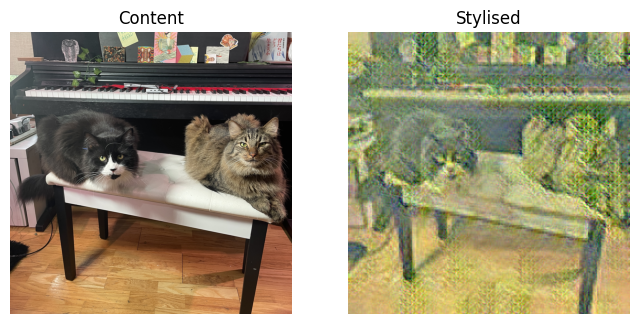

In [ ]:
# load the model
ckpt = sorted(glob.glob(f"{OUT_DIR}/ckpt_*.pth"))[-1]   # latest
transformer.load_state_dict(torch.load(ckpt, map_location=device))
transformer.eval()

# load the image
image_path = "data/train2014_1/IMG_7008.jpg"
test_img = Image.open(image_path)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(test_img); plt.title("Content"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(tensor_to_vis(out)[0]); plt.title("Stylised"); plt.axis("off")
plt.show()


In [ ]:
torch.save(transformer.state_dict(), f"{OUT_DIR}/final_{STYLE_PATH.split('/')[-1].split('.')[0]}.pth")
print("Saved final model!")

Saved final model!
